In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 96.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 29.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 107.1 MB/s eta 0:00:00


In [ ]:
import torch
import time
import math
import torch
import random
import numpy as np
import torch.nn as nn
import statistics as stats
import matplotlib.pyplot as plt
from torch import nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import SubsetRandomSampler, Dataset, DataLoader, random_split
from utils import get_onehot, original_dataset, calculate_energy, MyDataset, filter_by_length, filter_by_energy, find_extremes, custom_collate
from models import PositionalEncoding, RNATransformer, DistilBertForRegression
from train import train

import transformers
from transformers import DistilBertForSequenceClassification, AdamW, DistilBertConfig, DistilBertTokenizer, DistilBertModel

In [ ]:
!unzip /content/train_dataV2.pt.zip

Archive:  /content/train_dataV2.pt.zip
  inflating: train_dataV2.pt         
  inflating: __MACOSX/._train_dataV2.pt  


In [ ]:
# Load the data from the file using torch.load()
loaded_data = torch.load("/content/train_dataV2.pt")
len(loaded_data)

105294


# 05/06
## TrainDataV2, 13000 RNA data
* beta3: d_model=128, dim_feedforward=d_model*6, 300 epoch, longest 800

In [ ]:
# Set the input, hidden, and output sizes
input_size = 18
d_model = 128
nhead = 8
num_layers = 6
dropout = 0.2
epochs = 100

# Create the model
model = RNATransformer(input_size, d_model, nhead, num_layers, dropout)
model.cuda()

# Define the loss function and optimizer
criterion = nn.MSELoss()
# optimizer = optim.Adam(model.parameters(), lr=0.00005, betas=(0.5, 0.999))

# v2 beta2 use AdamW 
optim = torch.optim.AdamW(model.parameters(),lr=0.00005,  betas=(0.5, 0.999))

# scheduler
# scheduler = StepLR(optim, step_size=20, gamma=0.5)

print(model)

RNATransformer(
  (embedding): Linear(in_features=18, out_features=128, bias=True)
  (layer_norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (pos_encoder): PositionalEncoding(
    (dropout): Dropout(p=0.2, inplace=False)
  )
  (transformer): TransformerEncoder(
    (layers): ModuleList(
      (0-5): 6 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
        )
        (linear1): Linear(in_features=128, out_features=768, bias=True)
        (dropout): Dropout(p=0.2, inplace=False)
        (linear2): Linear(in_features=768, out_features=128, bias=True)
        (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.2, inplace=False)
        (dropout2): Dropout(p=0.2, inplace=False)
      )
    )
  )
  (fc): L

In [ ]:
# for beta3

# input_size = 18
# d_model = 128
# dim_feedforward=d_model*6
# nhead = 8
# num_layers = 6
# dropout = 0.2
# epochs = 100
# lr 0.00005

log3 = train(model, criterion, optim, epochs, scheduler=None)

2/100 Epochs | Train Loss=239.5912 | Val_loss=227.1583
Time elapsed: 1.14 min
4/100 Epochs | Train Loss=133.5536 | Val_loss=129.0347
Time elapsed: 2.28 min
6/100 Epochs | Train Loss=105.3683 | Val_loss=111.6125
Time elapsed: 3.44 min
8/100 Epochs | Train Loss=100.9232 | Val_loss=108.5752
Time elapsed: 4.59 min
10/100 Epochs | Train Loss=99.3212 | Val_loss=112.8607
Time elapsed: 5.75 min
12/100 Epochs | Train Loss=96.5328 | Val_loss=107.0693
Time elapsed: 6.90 min
14/100 Epochs | Train Loss=96.9366 | Val_loss=108.6745
Time elapsed: 8.06 min
16/100 Epochs | Train Loss=96.3091 | Val_loss=105.1929
Time elapsed: 9.22 min
18/100 Epochs | Train Loss=95.0222 | Val_loss=107.4047
Time elapsed: 10.38 min
20/100 Epochs | Train Loss=94.1697 | Val_loss=105.9688
Time elapsed: 11.54 min
22/100 Epochs | Train Loss=93.7606 | Val_loss=105.2310
Time elapsed: 12.69 min
24/100 Epochs | Train Loss=93.6342 | Val_loss=104.8178
Time elapsed: 13.86 min
26/100 Epochs | Train Loss=93.2619 | Val_loss=101.8600
Time 

In [ ]:
torch.save(model.state_dict(), '/content/transformerV2_beta3_100epoch.pt.pt')

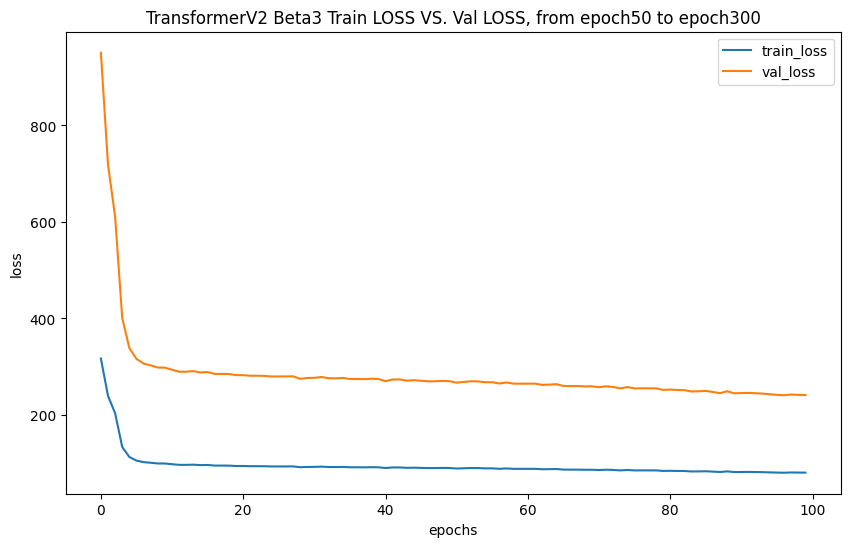

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(log3['train_loss'], label = 'train_loss')
plt.plot(log3['val_loss'], label = 'val_loss')
plt.legend()
plt.title('TransformerV2 Beta3 Train LOSS VS. Val LOSS, from epoch50 to epoch300')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()

In [ ]:
input_size = 18
d_model = 128
nhead = 8
num_layers = 6
dropout = 0.2

model_ = RNATransformer(input_size, d_model, nhead, num_layers, dropout)
model_.load_state_dict(torch.load('/content/transformerV2_beta3_100epoch.pt'))
model_.cuda()

RNATransformer(
  (embedding): Linear(in_features=18, out_features=128, bias=True)
  (layer_norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (pos_encoder): PositionalEncoding(
    (dropout): Dropout(p=0.2, inplace=False)
  )
  (transformer): TransformerEncoder(
    (layers): ModuleList(
      (0-5): 6 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
        )
        (linear1): Linear(in_features=128, out_features=768, bias=True)
        (dropout): Dropout(p=0.2, inplace=False)
        (linear2): Linear(in_features=768, out_features=128, bias=True)
        (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.2, inplace=False)
        (dropout2): Dropout(p=0.2, inplace=False)
      )
    )
  )
  (fc): L

In [ ]:
pred = []
true = []

model_.eval()
for i, (data, labels) in enumerate(test_loader):
    data = data.float()
    labels = labels.float()
    true.append(labels)

    if torch.cuda.is_available():
        data = data.cuda()
        labels = labels.cuda()
                    
    with torch.no_grad():
        predictions = model_(data)
        pred.append(predictions)


In [ ]:
pred_energy = []
for i in range(len(pred)):
    for j in pred[i]:
        pred_energy.append(j.cpu().item())
test_energy = []
for i in range(len(true)):
    for j in true[i]:
        test_energy.append(j.cpu().item())

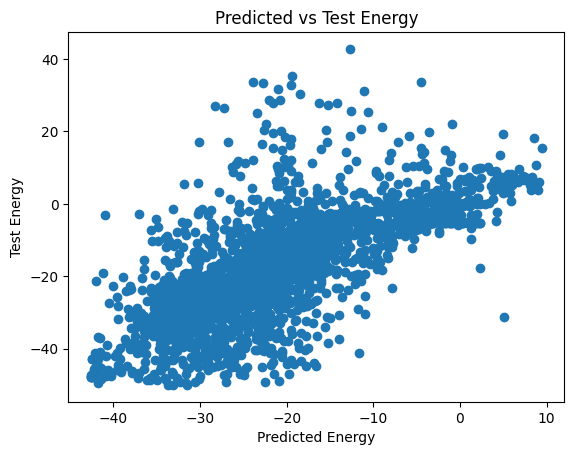

In [ ]:
plt.scatter(pred_energy, test_energy)
# Add axis labels and title
plt.title("Predicted vs Test Energy")
plt.xlabel("Predicted Energy")
plt.ylabel("Test Energy")

# Show the plot
plt.show()

# Try a pretrained DistilBert
* only applies to sequence that is shorter than 512

In [ ]:
input_dim = 18  # Replace this with the actual dimension of your one-hot encoding
model_name = 'distilbert-base-uncased'
config = DistilBertConfig.from_pretrained(model_name)
# config.max_position_embeddings = 800  # Set this value to the maximum sequence length in your dataset

regression_model = DistilBertForRegression(config, input_dim)

# Load pre-trained weights only for the DistilBertModel part
pretrained_distilbert = DistilBertModel.from_pretrained(model_name)
regression_model.distilbert.load_state_dict(pretrained_distilbert.state_dict())

# Freeze the parameters of the DistilBertModel part
# for param in regression_model.distilbert.parameters():
#     param.requires_grad = False

# Unfreeze embedding, pre_classifier, and classifier layers are unfrozen
# for layer in [regression_model.embedding, regression_model.pre_classifier, regression_model.classifier]:
#     for param in layer.parameters():
#         param.requires_grad = True

regression_model.cuda()

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


DistilBertForRegression(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
            (

In [ ]:
epochs = 60 # epoch_200 model does not saved due to lost connections -> 400 min training
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.AdamW(regression_model.parameters(), lr=1e-5, betas=(0.5, 0.999))

bert_log1 = train(regression_model, loss_fn, optimizer, epochs, scheduler=None)

2/60 Epochs | Train Loss=132.4040 | Val_loss=104.5645
Time elapsed: 4.13 min
4/60 Epochs | Train Loss=97.9195 | Val_loss=100.3175
Time elapsed: 8.31 min
6/60 Epochs | Train Loss=92.0663 | Val_loss=88.8013
Time elapsed: 12.56 min
8/60 Epochs | Train Loss=90.7167 | Val_loss=87.5714
Time elapsed: 16.73 min
10/60 Epochs | Train Loss=88.7069 | Val_loss=87.3294
Time elapsed: 20.91 min
12/60 Epochs | Train Loss=86.7526 | Val_loss=83.8013
Time elapsed: 25.11 min
14/60 Epochs | Train Loss=86.2259 | Val_loss=85.1258
Time elapsed: 29.31 min
16/60 Epochs | Train Loss=84.0641 | Val_loss=91.2555
Time elapsed: 33.52 min
18/60 Epochs | Train Loss=82.1932 | Val_loss=82.3790
Time elapsed: 37.72 min
20/60 Epochs | Train Loss=80.5524 | Val_loss=83.0862
Time elapsed: 41.93 min
22/60 Epochs | Train Loss=79.4976 | Val_loss=85.6900
Time elapsed: 46.19 min
24/60 Epochs | Train Loss=78.8308 | Val_loss=81.4429
Time elapsed: 50.38 min
26/60 Epochs | Train Loss=77.6206 | Val_loss=77.7157
Time elapsed: 54.54 min
28

In [ ]:
torch.save(regression_model.state_dict(), '/content/DistilBertV1.pt')

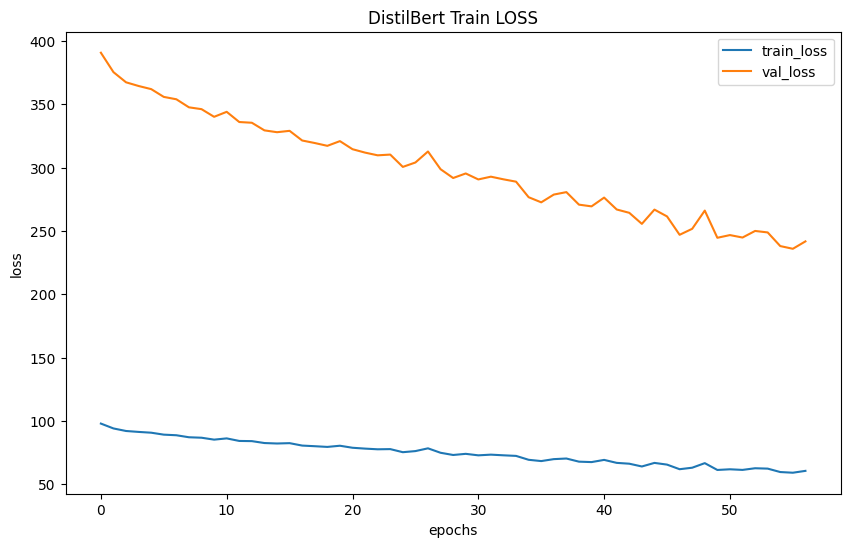

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))
plt.plot(bert_log1['train_loss'][3:60], label = 'train_loss')
plt.plot(bert_log1['val_loss'][3:60], label = 'val_loss')
plt.legend()
plt.title('DistilBert Train LOSS')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()
# loss might be miscalculated

## load and make predictions

In [ ]:
input_dim = 18  # Replace this with the actual dimension of your one-hot encoding
model_name = 'distilbert-base-uncased'
config = DistilBertConfig.from_pretrained(model_name)

dbmodel = DistilBertForRegression(config, input_dim)
dbmodel.load_state_dict(torch.load('/content/DistilBertV1.pt'))
dbmodel.cuda()

DistilBertForRegression(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
            (

In [ ]:
pred = []
true = []

dbmodel.eval()
for i, (data, labels) in enumerate(test_loader):
    data = data.float()
    labels = labels.float()
    true.append(labels)

    if torch.cuda.is_available():
        data = data.cuda()
        labels = labels.cuda()
        
    with torch.no_grad():

        predictions = dbmodel(data)
        pred.append(predictions)


In [ ]:
pred_energy = []
for i in range(len(pred)):
    for j in pred[i]:
        pred_energy.append(j.cpu().item())
test_energy = []
for i in range(len(true)):
    for j in true[i]:
        test_energy.append(j.cpu().item())

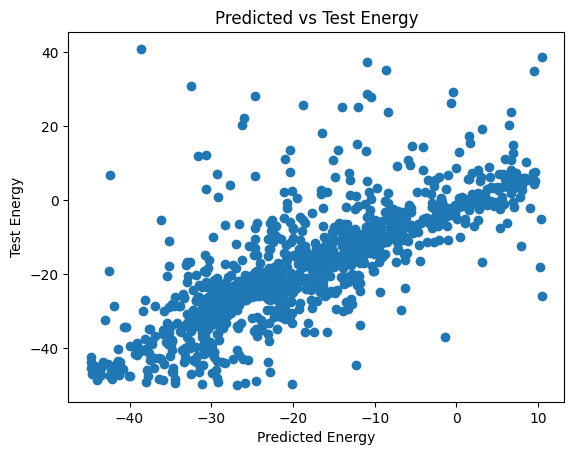

In [ ]:
import matplotlib.pyplot as plt

plt.scatter(pred_energy, test_energy)
# Add axis labels and title
plt.title("Predicted vs Test Energy")
plt.xlabel("Predicted Energy")
plt.ylabel("Test Energy")

# Show the plot
plt.show()

In [ ]:
import scipy.stats as scipyStats
r, p_value = scipyStats.pearsonr(pred_energy, test_energy)

print("R score:", r)

R score: 0.8121590077671286
